In [1]:
import pandas as pd
import numpy as np
import torch
from torchtext import data
import random
import re
import seaborn as sns
import matplotlib.pyplot as plt 

import booksummarydataset
import genre_prediction_models
from booksummarydataset import VALID_GENRES as valid_genres
from booksummarydataset import N_CLASSES as n_classes
from booksummarydataset import TARGETS as targets
from booksummarydataset import SummaryDataSet

from genre_prediction_models import train
from genre_prediction_models import test
from genre_prediction_models import LSTMClassifier
from genre_prediction_models import GRUClassifier

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#from sklearn.model_selection import train_test_split
total_dataset = SummaryDataSet(filepath="/kaggle/input/book-genre-prediction-data-preparation/book_summaries.csv")
train_dataset = SummaryDataSet(filepath="/kaggle/input/book-genre-prediction-data-preparation/book_summaries_train.csv")
valid_dataset = SummaryDataSet(filepath="/kaggle/input/book-genre-prediction-data-preparation/book_summaries_valid.csv")
test_dataset = SummaryDataSet(filepath="/kaggle/input/book-genre-prediction-data-preparation/book_summaries_test.csv")

#Split to train and test data
#train_dataset, valid_test_dataset = train_test_split(total_dataset, random_state=42, test_size=0.2, shuffle=True, stratify=total_dataset.book_summary_df['Genres'])
#valid_dataset, test_dataset = train_test_split(valid_test_dataset, random_state=42, test_size=0.15, shuffle=True)
print("Total Training Dataset = {}, Valid Dataset = {} and Test Dataset = {}".format(len(train_dataset),len(valid_dataset),len(test_dataset)))

Total Training Dataset = 11566, Valid Dataset = 1429 and Test Dataset = 613


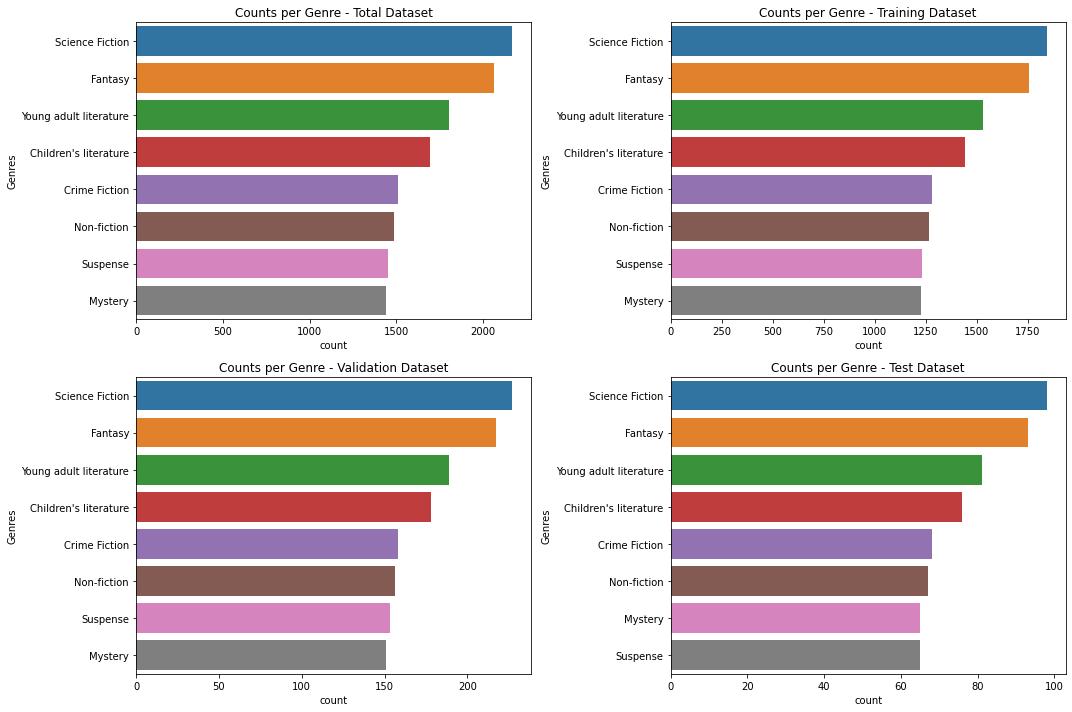

In [4]:
def plot_dataset(dataset, title):
    sns.countplot(data=dataset, order=dataset.Genres.value_counts().index, y='Genres')
    plt.title("Counts per Genre - {}".format(title))
    #plt.show()

plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plot_dataset(total_dataset.book_summary_df,"Total Dataset")
plt.subplot(2,2,2)
plot_dataset(train_dataset.book_summary_df, "Training Dataset")
plt.subplot(2,2,3)
plot_dataset(valid_dataset.book_summary_df, "Validation Dataset")
plt.subplot(2,2,4)
plot_dataset(test_dataset.book_summary_df, "Test Dataset")
plt.tight_layout()
plt.show()

In [5]:
import nltk
from nltk.corpus import stopwords
from torchtext.data.utils import get_tokenizer

import string
stopwords = set(stopwords.words("english"))
# Function to convert text to words.
def tokenizer(text):
    nltk.download('stopwords', quiet=True)
    tk = get_tokenizer('basic_english')
    words = tk(text)
    words = [w for w in words if w not in stopwords]
    return words

In [6]:
from collections import Counter
from torchtext.vocab import Vocab

counter = Counter()
for (summary, genre) in train_dataset:
    counter.update(tokenizer(summary))
vocab = Vocab(counter, min_freq=10, specials=('<unk>', '<BOS>', '<EOS>', '<PAD>'))

Alternatively, one of or a list of available pretrained vectors:

* charngram.100d
* fasttext.en.300d
* fasttext.simple.300d
* glove.42B.300d
* glove.840B.300d
* glove.twitter.27B.25d
* glove.twitter.27B.50d
* glove.twitter.27B.100d
* glove.twitter.27B.200d
* glove.6B.50d
* glove.6B.100d
* glove.6B.200d
* buzonurbanismo@rivasciudad.es  glove.6B.300 d

In [7]:
#'glove.6B.300d'
#fasttext.simple.300d
# 'charngram.100d'

pretrained = ['glove.6B.50d','glove.6B.300d', 
              'charngram.100d', 'fasttext.simple.300d', 
              'fasttext.en.300d', 'glove.42B.300d',
              'glove.840B.300d', 'glove.twitter.27B.100d']
vocab.load_vectors(pretrained[4])
embedding = vocab.vectors.to(device)

.vector_cache/wiki.en.vec: 6.60GB [02:34, 42.8MB/s]                            
100%|██████████| 2519370/2519370 [05:31<00:00, 7608.35it/s]


In [8]:
def save_vocab(vocab, path):
    import pickle
    output = open(path, 'wb')
    pickle.dump(vocab, output)
    output.close()

In [9]:
def load_vocab(path):
    import pickle
    out = open(path, 'rb')
    new_vocab = pickle.load(out)
    out.close()
    return new_vocab

In [10]:
save_vocab(vocab=vocab, path='./vocab.pkl')
#new_vocab = load_vocab('./vocab.pkl')

In [11]:
print("The length of the new vocab is", len(vocab))
new_stoi = vocab.stoi
print("The index of '<BOS>' is", new_stoi['<BOS>'])
new_itos = vocab.itos
print("The token at index 2 is", new_itos[2])
print("Size of vocabulary: ", len(vocab))
print(vocab.freqs.most_common(10))

The length of the new vocab is 20618
The index of '<BOS>' is 1
The token at index 2 is <EOS>
Size of vocabulary:  20618
[('one', 10918), ('new', 6744), ('time', 6376), ('life', 5974), ('two', 5566), ('also', 5449), ('world', 5383), ('back', 5194), ('find', 5160), ('book', 5105)]


In [12]:
text_transform = lambda x: [vocab['<BOS>']] + [vocab[token] for token in tokenizer(x)] + [vocab['<EOS>']]
label_transform = lambda x: valid_genres[x]

In [13]:
# Print out the output of text_transform
print("input to the text_transform:", "here is an example")
print("output of the text_transform:", text_transform("here is an example"))

input to the text_transform: here is an example
output of the text_transform: [1, 1546, 2]


In [14]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
BATCH_SIZE = 64

def collate_batch(batch):
    label_list, text_list = [], []
    for (text, label) in batch:
        label_list.append(torch.tensor(label_transform(label)))
        processed_text = torch.tensor(text_transform(text))
        text_list.append(processed_text)
    text_pad = pad_sequence(text_list, batch_first=True)
    #label_pad = pad_sequence(label_list, batch_first=True)
    return text_pad, torch.tensor(label_list)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda x: collate_batch(x), drop_last=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda x: collate_batch(x), drop_last=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda x: collate_batch(x), drop_last=True)
print(len(train_dataloader))

180


In [15]:
#define hyperparameters
size_of_vocab = len(vocab)
hidden_dim = 128
n_layers = 4
epochs=10

# Create and Train Models

In [16]:
model_gru = GRUClassifier(vocab_size=size_of_vocab, embedding_dim=embedding.shape[1],hidden_dim=hidden_dim, n_layers=n_layers, n_classes=n_classes, batch_size=BATCH_SIZE)
model_gru = model_gru.to(device)
#architecture
print(model_gru)

GRUClassifier(
  (embedding): Embedding(20618, 300)
  (gru): GRU(300, 128, num_layers=4, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=256, out_features=8, bias=True)
)


In [17]:
model_lstm = LSTMClassifier(vocab_size=size_of_vocab, embedding_dim=embedding.shape[1],hidden_dim=hidden_dim, n_layers=n_layers, n_classes=n_classes, batch_size=BATCH_SIZE)
model_lstm = model_lstm.to(device)

#architecture
print(model_lstm)

LSTMClassifier(
  (embedding): Embedding(20618, 300)
  (lstm): LSTM(300, 128, num_layers=4, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=256, out_features=8, bias=True)
)


Load pre-trained embedding models.

In [18]:
#Initialize the pretrained embedding
pretrained_embeddings = vocab.vectors
model_lstm.embedding.weight.data.copy_(pretrained_embeddings)
#model_lstm.embedding.weight.requires_grad=False

model_gru.embedding.weight.data.copy_(pretrained_embeddings)
model_gru.embedding.weight.requires_grad=True

print(pretrained_embeddings.shape)

torch.Size([20618, 300])


In [19]:
loss_fn = torch.nn.CrossEntropyLoss().to(device)

In [20]:
(train_losses_lstm, val_losses_lstm, total_accuracy_lstm) = train(model=model_lstm, epochs=epochs, train_dataloader=train_dataloader, valid_loader=valid_loader,
                                                                    filename="./state_dict_model_lstm.pt", loss_fn=loss_fn, device=device)

 10%|█         | 1/10 [02:30<22:37, 150.82s/it]

Model saved!
Epoch 1:	Training took 145.14[s]	Validation took: 5.68[s]
Losses:  	Training Loss:1.725429   	Validation Loss: 1.468971	Accuracy: 32.3102%
------------------------------------------------------------------------------------------------


 20%|██        | 2/10 [05:01<20:06, 150.86s/it]

Model saved!
Epoch 2:	Training took 145.17[s]	Validation took: 5.71[s]
Losses:  	Training Loss:1.411857   	Validation Loss: 1.365698	Accuracy: 44.0688%
------------------------------------------------------------------------------------------------


 30%|███       | 3/10 [07:32<17:36, 150.98s/it]

Epoch 3:	Training took 145.48[s]	Validation took: 5.65[s]
Losses:  	Training Loss:1.229695   	Validation Loss: 1.367968	Accuracy: 51.3142%
------------------------------------------------------------------------------------------------


 40%|████      | 4/10 [10:03<15:05, 150.90s/it]

Model saved!
Epoch 4:	Training took 145.25[s]	Validation took: 5.52[s]
Losses:  	Training Loss:1.093238   	Validation Loss: 1.300175	Accuracy: 56.5105%
------------------------------------------------------------------------------------------------


 50%|█████     | 5/10 [12:34<12:34, 150.96s/it]

Epoch 5:	Training took 145.43[s]	Validation took: 5.62[s]
Losses:  	Training Loss:0.972214   	Validation Loss: 1.358117	Accuracy: 60.6865%
------------------------------------------------------------------------------------------------


 60%|██████    | 6/10 [15:05<10:03, 150.91s/it]

Epoch 6:	Training took 145.21[s]	Validation took: 5.62[s]
Losses:  	Training Loss:0.888035   	Validation Loss: 1.408465	Accuracy: 64.7415%
------------------------------------------------------------------------------------------------


 70%|███████   | 7/10 [17:36<07:32, 150.80s/it]

Epoch 7:	Training took 144.93[s]	Validation took: 5.65[s]
Losses:  	Training Loss:0.823418   	Validation Loss: 1.475714	Accuracy: 67.5947%
------------------------------------------------------------------------------------------------


 80%|████████  | 8/10 [20:07<05:01, 150.92s/it]

Epoch 8:	Training took 145.53[s]	Validation took: 5.65[s]
Losses:  	Training Loss:0.773893   	Validation Loss: 1.472143	Accuracy: 70.4046%
------------------------------------------------------------------------------------------------


 90%|█████████ | 9/10 [22:38<02:30, 150.97s/it]

Epoch 9:	Training took 145.40[s]	Validation took: 5.68[s]
Losses:  	Training Loss:0.688510   	Validation Loss: 1.463820	Accuracy: 73.6815%
------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [25:09<00:00, 150.93s/it]

Epoch 10:	Training took 145.45[s]	Validation took: 5.53[s]
Losses:  	Training Loss:0.631964   	Validation Loss: 1.536991	Accuracy: 76.0246%
------------------------------------------------------------------------------------------------


In [21]:
(train_losses_gru, val_losses_gru, total_accuracy_gru) = train(model=model_gru, epochs=epochs, train_dataloader=train_dataloader, valid_loader=valid_loader,
                                                                    filename="./state_dict_model_gru.pt", loss_fn=loss_fn, device=device)

 10%|█         | 1/10 [02:11<19:43, 131.46s/it]

Model saved!
Epoch 1:	Training took 127.64[s]	Validation took: 3.82[s]
Losses:  	Training Loss:1.544234   	Validation Loss: 1.212406	Accuracy: 39.7804%
------------------------------------------------------------------------------------------------


 20%|██        | 2/10 [04:22<17:28, 131.08s/it]

Model saved!
Epoch 2:	Training took 127.01[s]	Validation took: 3.80[s]
Losses:  	Training Loss:1.099205   	Validation Loss: 1.138508	Accuracy: 56.5278%
------------------------------------------------------------------------------------------------


 30%|███       | 3/10 [06:32<15:15, 130.77s/it]

Epoch 3:	Training took 126.91[s]	Validation took: 3.48[s]
Losses:  	Training Loss:0.853768   	Validation Loss: 1.267672	Accuracy: 66.6868%
------------------------------------------------------------------------------------------------


 40%|████      | 4/10 [08:43<13:03, 130.65s/it]

Epoch 4:	Training took 126.85[s]	Validation took: 3.61[s]
Losses:  	Training Loss:0.669337   	Validation Loss: 1.358781	Accuracy: 74.4164%
------------------------------------------------------------------------------------------------


 50%|█████     | 5/10 [10:55<10:55, 131.11s/it]

Epoch 5:	Training took 127.96[s]	Validation took: 3.97[s]
Losses:  	Training Loss:0.509922   	Validation Loss: 1.583061	Accuracy: 81.1344%
------------------------------------------------------------------------------------------------


 60%|██████    | 6/10 [13:06<08:44, 131.07s/it]

Epoch 6:	Training took 127.48[s]	Validation took: 3.51[s]
Losses:  	Training Loss:0.390859   	Validation Loss: 1.608612	Accuracy: 85.8205%
------------------------------------------------------------------------------------------------


 70%|███████   | 7/10 [15:17<06:33, 131.11s/it]

Epoch 7:	Training took 127.32[s]	Validation took: 3.88[s]
Losses:  	Training Loss:0.304911   	Validation Loss: 1.693868	Accuracy: 89.1752%
------------------------------------------------------------------------------------------------


 80%|████████  | 8/10 [17:28<04:22, 131.05s/it]

Epoch 8:	Training took 127.00[s]	Validation took: 3.92[s]
Losses:  	Training Loss:0.221863   	Validation Loss: 1.891715	Accuracy: 92.0975%
------------------------------------------------------------------------------------------------


 90%|█████████ | 9/10 [19:38<02:10, 130.86s/it]

Epoch 9:	Training took 126.90[s]	Validation took: 3.52[s]
Losses:  	Training Loss:0.179988   	Validation Loss: 2.043648	Accuracy: 93.6452%
------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [21:49<00:00, 130.95s/it]

Epoch 10:	Training took 127.31[s]	Validation took: 3.61[s]
Losses:  	Training Loss:0.126656   	Validation Loss: 2.255304	Accuracy: 95.5732%
------------------------------------------------------------------------------------------------


# Plot the Losses and Accuracy.

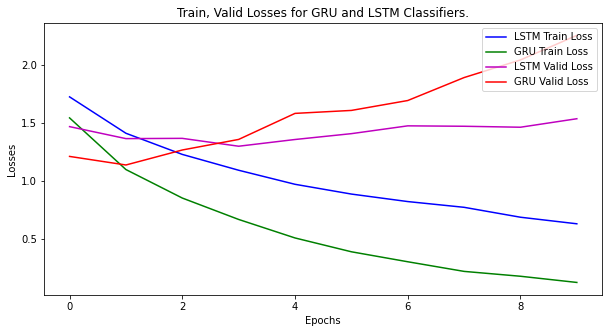

In [22]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(train_losses_lstm, 'b', label='LSTM Train Loss')
plt.plot(train_losses_gru, 'g', label='GRU Train Loss')
plt.plot(val_losses_lstm, 'm', label='LSTM Valid Loss')
plt.plot(val_losses_gru, 'r', label='GRU Valid Loss')
plt.legend(loc='upper right')
plt.title("Train, Valid Losses for GRU and LSTM Classifiers.")
plt.ylabel("Losses")
plt.xlabel("Epochs")
plt.show()

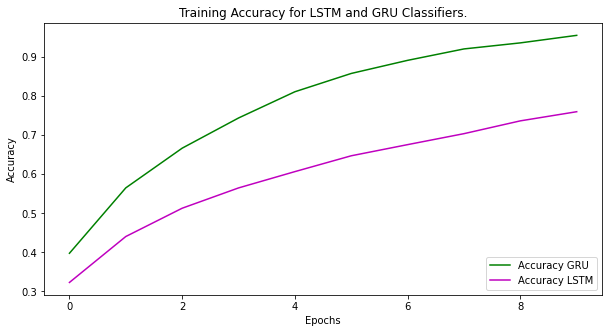

In [23]:
plt.figure(figsize=(10,5))
plt.plot(total_accuracy_gru, 'g', label='Accuracy GRU')
plt.plot(total_accuracy_lstm, 'm', label='Accuracy LSTM')
plt.legend(loc='lower right')
plt.title("Training Accuracy for LSTM and GRU Classifiers.")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

# Test the model.
First load the saved model.

In [24]:
model_lstm = LSTMClassifier(vocab_size=size_of_vocab, embedding_dim=embedding.shape[1],hidden_dim=hidden_dim, n_layers=n_layers, n_classes=n_classes, batch_size=BATCH_SIZE)
model_lstm.load_state_dict(torch.load('./state_dict_model_lstm.pt'))
model_lstm = model_lstm.to(device)
model_gru = GRUClassifier(vocab_size=size_of_vocab, embedding_dim=embedding.shape[1],hidden_dim=hidden_dim, n_layers=n_layers, n_classes=n_classes, batch_size=BATCH_SIZE)
model_gru.load_state_dict(torch.load('./state_dict_model_gru.pt'))
model_gru = model_gru.to(device)

Testing LSTM Model.
Test loss: 1.292
##########################################
#	Test accuracy is 48.9583%	#
##########################################
------------------------------------------------------------
Classification Report for model LSTM Classifier
------------------------------------------------------------
                        precision    recall  f1-score   support

       Science Fiction       0.39      0.25      0.30        69
         Crime Fiction       0.36      0.66      0.46        64
           Non-fiction       0.74      0.42      0.53        89
 Children's literature       0.22      0.08      0.12        60
               Fantasy       0.84      0.74      0.79        62
               Mystery       0.62      0.83      0.71        96
              Suspense       0.27      0.21      0.24        62
Young adult literature       0.38      0.57      0.46        74

              accuracy                           0.49       576
             macro avg       0.48  

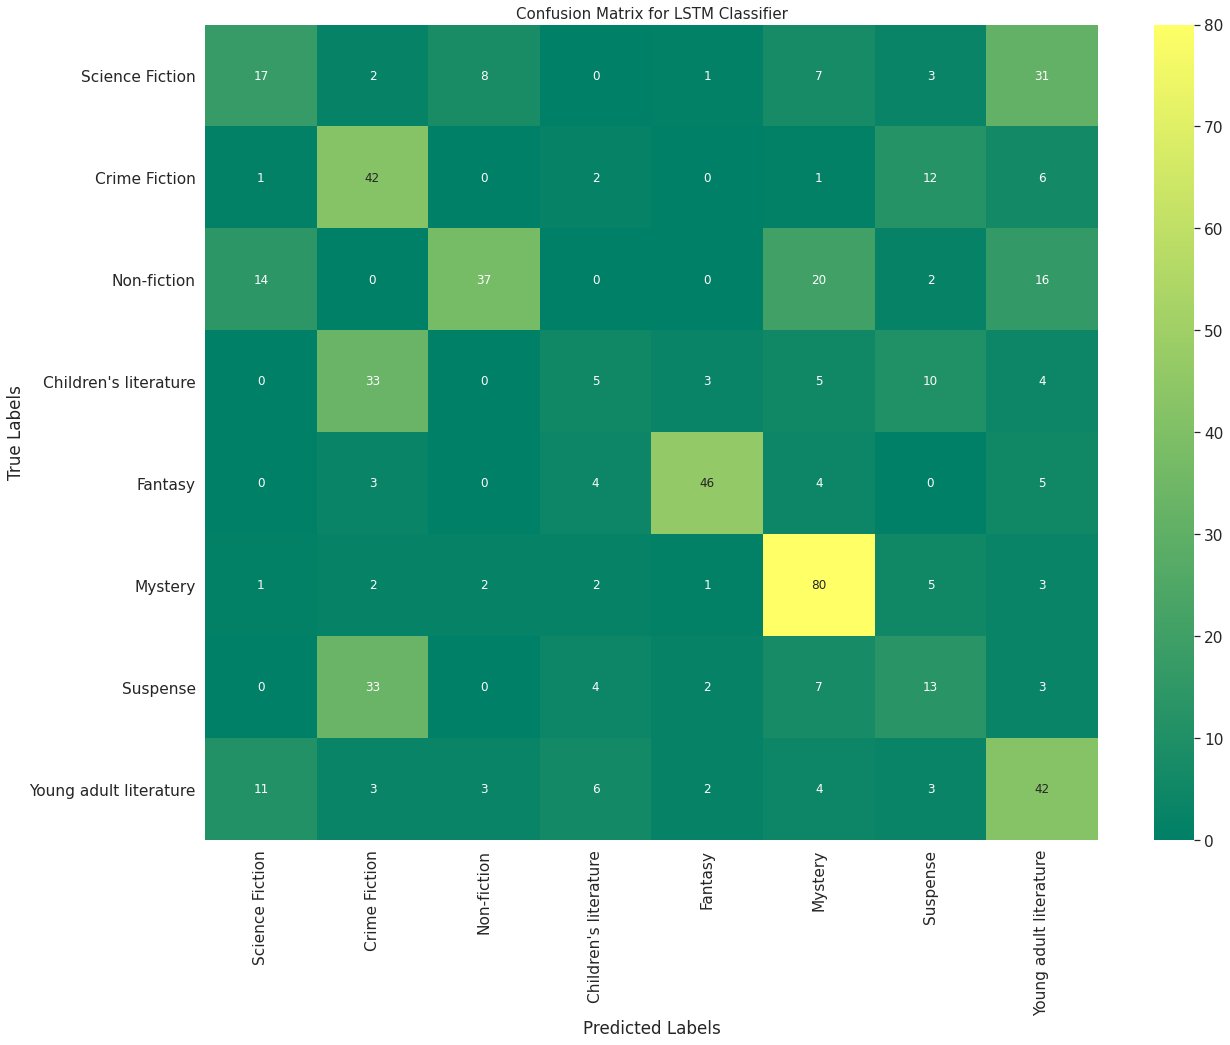

In [25]:
print("Testing LSTM Model.")
test(model=model_lstm, test_loader=test_loader, loss_fn=loss_fn, device=device, targets=targets)

Testing GRU Model.
Test loss: 1.203
##########################################
#	Test accuracy is 54.6875%	#
##########################################
------------------------------------------------------------
Classification Report for model GRU Classifier
------------------------------------------------------------
                        precision    recall  f1-score   support

       Science Fiction       0.57      0.49      0.53        69
         Crime Fiction       0.32      0.12      0.18        64
           Non-fiction       0.70      0.64      0.67        89
 Children's literature       0.35      0.48      0.40        60
               Fantasy       0.93      0.69      0.80        62
               Mystery       0.64      0.79      0.71        96
              Suspense       0.40      0.27      0.33        62
Young adult literature       0.43      0.69      0.53        74

              accuracy                           0.55       576
             macro avg       0.54    

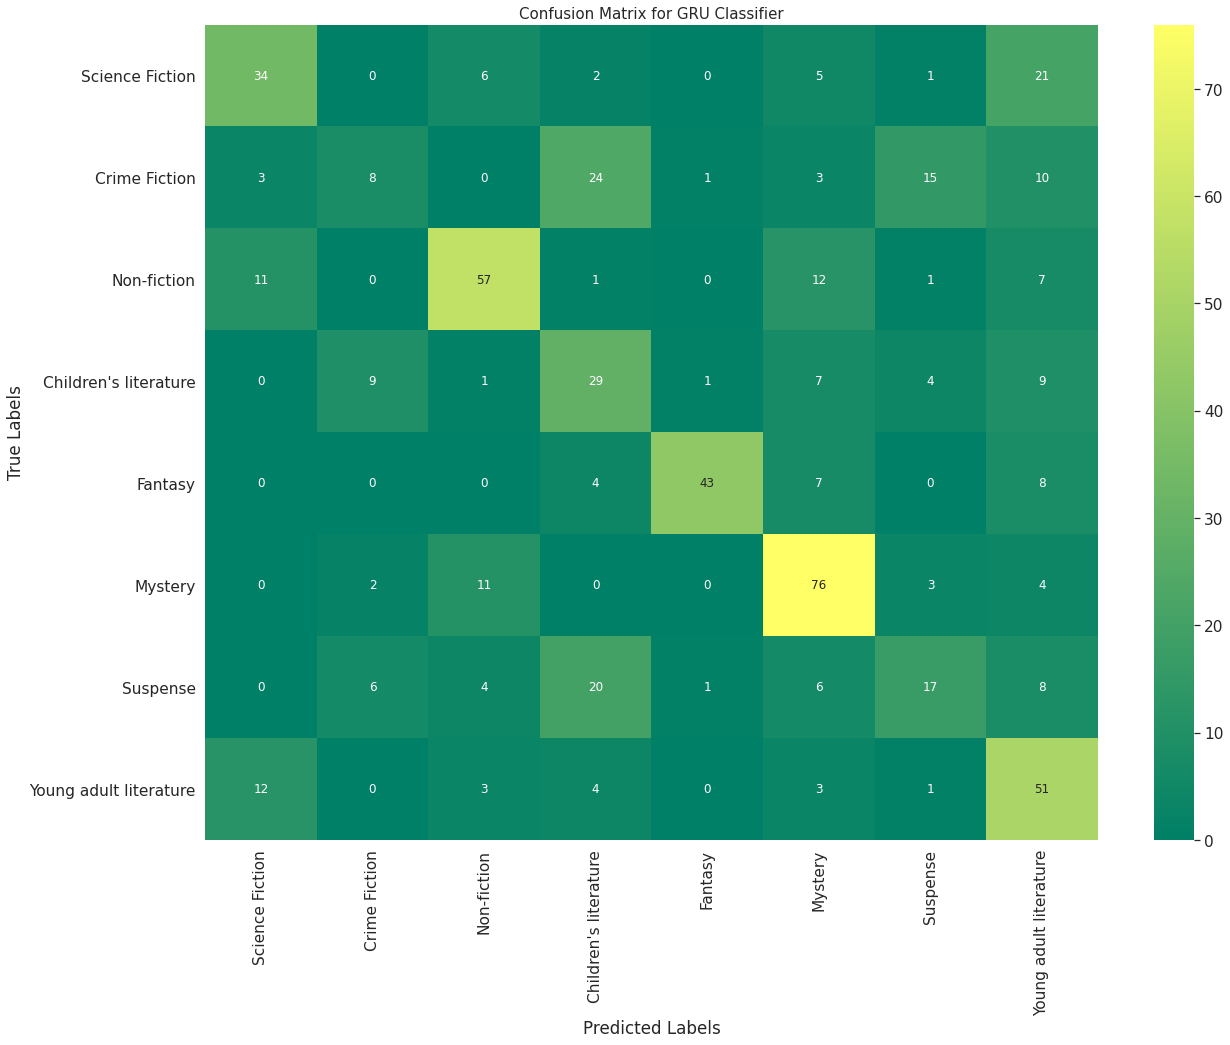

In [26]:
print("Testing GRU Model.")
test(model=model_gru, test_loader=test_loader, loss_fn=loss_fn, device=device, targets=targets)

In [27]:
"""
import nltk
from nltk.corpus import stopwords
from torchtext.data.utils import get_tokenizer

import string
stopwords = set(stopwords.words("english"))
# Function to convert text to words.
def tokenizer(text):
    nltk.download('stopwords', quiet=True)
    tk = get_tokenizer('basic_english')
    words = tk(text)
    words = [w for w in words if w not in stopwords]
    return words
"""
def predict_genre(plot, model, device):
    
    vocab = load_vocab('./vocab.pkl')
    text_transform = lambda x: [vocab['<BOS>']] + [vocab[token] for token in tokenizer(x)] + [vocab['<EOS>']]
    #Tokenize
    tokenized = tokenizer(plot)
    indexed = torch.tensor(text_transform(plot))
    feature_plot =indexed.reshape(1, indexed.size(0))
    
    model.eval()
    feature_plot = feature_plot.to(device)
    output= model(feature_plot)
    pred = output.data.max(1, keepdim=True)[1]
    return genre_prediction_models.get_genre(pred)

In [28]:
import pandas as pd
testing_df = pd.read_csv(filepath_or_buffer='../input/load-summaries/summaries_for_testing.csv',
                         header=0, names=['title','author','genre','summary'])
titles = testing_df.title.to_numpy()
authors = testing_df.author.to_numpy()
genre = testing_df.genre.to_numpy()
summaries = testing_df.genre.to_numpy()

In [29]:
results= { 'Title': [],
           'Author': [],
           'Prediction LSTM': [],
           'Prediction GRU': [],
           'Genre': []
                }
print("*********Testing Results Models LSTM & GRU:***********")


for i in range(len(testing_df)):    
    #predict_genre(plot=summaries[i], title=titles[i], author=authors[i], model=model_gru, label=genre[i], device=device)
    results['Title'].append(titles[i])
    results['Author'].append(authors[i])
    results['Prediction LSTM'].append(predict_genre(plot=summaries[i], model=model_lstm, device=device))
    results['Prediction GRU'].append(predict_genre(plot=summaries[i], model=model_gru, device=device))
    results['Genre'].append(genre[i])
results_df = pd.DataFrame.from_dict(results, orient='columns')
results_df.head(10)

*********Testing Results Models LSTM & GRU:***********


,Title,Author,Prediction LSTM,Prediction GRU,Genre
0,A Court of Silver Flames,Sarah J. Maas,Children's literature,Children's literature,Fantasy
1,Winter's Orbit,Everina Maxwell,Science Fiction,Science Fiction,Science Fiction
2,The Electric Kingdom,David Arnold,Young adult literature,Young adult literature,Young adult literature
3,The Lost Apothecary,Sarah Penner,Mystery,Mystery,Mystery
4,Let Her Lie,Bryan Reardon,Crime Fiction,Suspense,Suspense
5,Four Lost Cities: A Secret History of the Urba...,Annalee Newitz,Mystery,Mystery,Non-fiction
6,The Year I Flew Away,Marie Arnold,Young adult literature,Young adult literature,Children's literature
7,Don't Overthink It,Anne Bogel,Mystery,Mystery,Non-fiction
8,Ready Player One,Ernest Cline,Science Fiction,Science Fiction,Speculative fiction
9,The Name of the Rose,Umberto Eco,Crime Fiction,Suspense,Crime Fiction
